File: frame_6.scfp.esp.cube
Count=1728000  min=-0.175824  max=109.269
mean=-0.00224828  std=0.520066
p05=-0.0793048  median=-0.0422833  p95=0.0673066
|V| p95 = 0.107601  -> symmetric range ≈ [-0.108, +0.108] a.u.


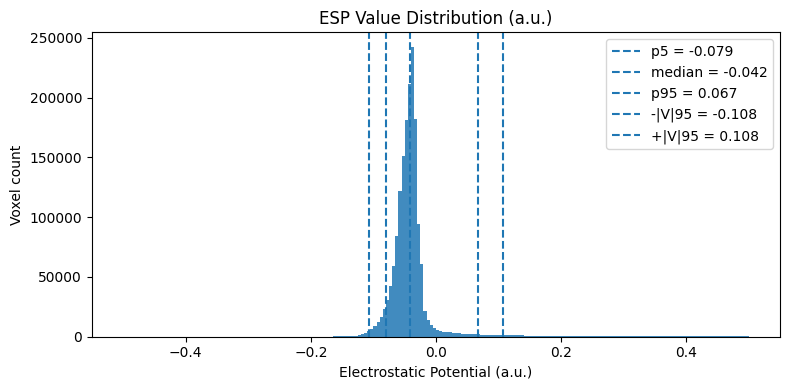

In [5]:
# --- Bullet-proof ESP histogram without np.histogram ---
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

def read_cube_values(cube_path):
    p = Path(cube_path)
    with p.open("r") as f:
        lines = f.readlines()
    # number of atoms (can be negative)
    natoms = int(lines[2].split()[0])
    natoms_abs = abs(natoms)
    header = 2 + 1 + 3 + natoms_abs  # 2 comments + 1 atomcount + 3 grid + natoms atom lines
    data = []
    for line in lines[header:]:
        parts = line.split()
        if parts:
            data.extend(map(float, parts))
    arr = np.asarray(data, dtype=float).reshape(-1)
    # keep only finite values (avoid NaN/inf issues)
    return arr[np.isfinite(arr)]

# ===== configure =====
cube_file = "frame_6.scfp.esp.cube"   # <-- change to your file name
bins = 200
xmin, xmax = -0.5, 0.5

# ===== load & stats =====
vals = read_cube_values(cube_file)
p05, p50, p95 = np.percentile(vals, [5, 50, 95])
v95_abs = np.percentile(np.abs(vals), 95)

print(f"File: {cube_file}")
print(f"Count={vals.size}  min={vals.min():.6g}  max={vals.max():.6g}")
print(f"mean={vals.mean():.6g}  std={vals.std():.6g}")
print(f"p05={p05:.6g}  median={p50:.6g}  p95={p95:.6g}")
print(f"|V| p95 = {v95_abs:.6g}  -> symmetric range ≈ [-{v95_abs:.3f}, +{v95_abs:.3f}] a.u.")

# ===== manual histogram (no np.histogram) =====
edges = np.linspace(xmin, xmax, int(bins) + 1, dtype=float)          # (bins+1,)
counts = np.zeros(int(bins), dtype=int)                               # (bins,)

# bin indices for each value
idx = np.searchsorted(edges, vals, side="right") - 1                  # [-1..bins-1]
# keep only those that fall inside our range
mask = (idx >= 0) & (idx < int(bins))
idx = idx[mask]

# accumulate counts per bin
np.add.at(counts, idx, 1)

# centers and widths for plotting
centers = 0.5 * (edges[:-1] + edges[1:])
widths  = np.diff(edges)

plt.figure(figsize=(8,4))
plt.bar(centers, counts, width=widths, align="center", alpha=0.85, edgecolor="none")

# percentile & symmetric cutoff guides
for x, lbl in [(p05, "p5"), (p50, "median"), (p95, "p95"),
               (-v95_abs, "-|V|95"), (v95_abs, "+|V|95")]:
    plt.axvline(float(x), linestyle="--", label=f"{lbl} = {float(x):.3f}")

plt.title("ESP Value Distribution (a.u.)")
plt.xlabel("Electrostatic Potential (a.u.)")
plt.ylabel("Voxel count")
plt.legend()
plt.tight_layout()
plt.show()
